In [1]:
!kaggle datasets download -d vasukipatel/face-recognition-dataset

Dataset URL: https://www.kaggle.com/datasets/vasukipatel/face-recognition-dataset
License(s): CC0-1.0
100% 725M/726M [00:03<00:00, 275MB/s]
100% 726M/726M [00:03<00:00, 248MB/s]


In [2]:
#Unzip the dataset
import zipfile
with zipfile.ZipFile('/content/face-recognition-dataset.zip', 'r') as zip_ref:
    zip_ref.extractall('/content/dataset')

In [3]:
import os
import shutil
import numpy as np
import pandas as pd
import cv2

In [4]:
# Paths to the face_images folder
original_images_folder = '/content/dataset/Faces/Faces'

new_images_folder = '/content/data'


if not os.path.exists(new_images_folder):
    os.makedirs(new_images_folder)

# List all files in the original directory
files = os.listdir(original_images_folder)

unique_names = set()

# Extract unique names from the file names
for file in files:
    if file.endswith('.jpg'):
        name_part = file.rsplit('_', 2)[0]
        unique_names.add(name_part)

# Create directories for each unique name in the new folder and copy files
for name in unique_names:
    name_dir = os.path.join(new_images_folder, name, 'faces')
    if not os.path.exists(name_dir):
        os.makedirs(name_dir)

    for file in files:
        if file.startswith(name):
            shutil.copy(os.path.join(original_images_folder, file), os.path.join(name_dir, file))

In [5]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Input, Lambda, BatchNormalization, GlobalAveragePooling2D
from tensorflow.keras.applications import InceptionResNetV2
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping
import tensorflow.keras.backend as K

In [6]:
# Data Preprocessing
def resize_and_normalize_image(image, size=(160, 160)):
    img = cv2.resize(image, size)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  # Convert to RGB
    img = img.astype('float32') / 255.0
    return img

# Load and preprocess data
source_dir = '/content/data'
person_names = os.listdir(source_dir)
class_mapping = {name: idx for idx, name in enumerate(person_names)}

face_images = []
labels = []

for name in person_names:
    img_dir_path = os.path.join(source_dir, name, 'faces')
    img_list = os.listdir(img_dir_path)
    for img in img_list:
        img_path = os.path.join(img_dir_path, img)
        image = cv2.imread(img_path)
        face_images.append(resize_and_normalize_image(image))
        labels.append(class_mapping[name])

face_images = np.array(face_images)
labels = np.array(labels)

print('Original data shape:', face_images.shape)



Original data shape: (2562, 160, 160, 3)


In [7]:
# Data augmentation
datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)


In [8]:
# Generate augmented data
batch_size = 32
augmented_images = []
augmented_labels = []

for x_batch, y_batch in datagen.flow(face_images, labels, batch_size=batch_size):
    augmented_images.extend(x_batch)
    augmented_labels.extend(y_batch)
    if len(augmented_images) >= len(face_images) * 5:  # Augmentation factor
        break

augmented_images = np.array(augmented_images)
augmented_labels = np.array(augmented_labels)

print('Augmented data shape:', augmented_images.shape)

Augmented data shape: (12810, 160, 160, 3)


In [9]:
# Combine original and augmented data
combined_images = np.concatenate((face_images, augmented_images), axis=0)
combined_labels = np.concatenate((labels, augmented_labels), axis=0)

print('Combined data shape:', combined_images.shape)

# Convert labels to categorical
num_classes = len(person_names)
combined_labels = to_categorical(combined_labels, num_classes=num_classes)

# Split data into training and validation sets
X_train_face, X_val_face, y_train_face, y_val_face = train_test_split(combined_images, combined_labels, test_size=0.2, random_state=42)


Combined data shape: (15372, 160, 160, 3)


In [10]:
# Build and fine-tune FaceNet model
def create_facenet_model():
    base_model = InceptionResNetV2(include_top=False, input_shape=(160, 160, 3), weights='imagenet')
    input = Input(shape=(160, 160, 3))
    x = base_model(input)
    x = GlobalAveragePooling2D()(x)
    x = Lambda(lambda x: K.l2_normalize(x, axis=1))(x)
    model = Model(input, x)
    return model

facenet_model = create_facenet_model()
for layer in facenet_model.layers[:-20]:  # Fine-tuning layers
    layer.trainable = False

219055592/219055592 [==============================] - 1s 0us/step


In [11]:
# Build the model with the correct architecture
def build_model_with_classification_head(base_model, num_classes):
    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    x = Dense(512, activation='relu')(x)
    x = BatchNormalization()(x)
    predictions = Dense(num_classes, activation='softmax')(x)
    return Model(inputs=base_model.input, outputs=predictions)


num_classes = 31

# Callbacks for training
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=1e-6, verbose=1)
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True, verbose=1)

# Instantiate base model without top layers
facenet_base = InceptionResNetV2(include_top=False, input_shape=(160, 160, 3), weights='imagenet')

facenet_model_with_head = build_model_with_classification_head(facenet_base, num_classes)

In [12]:
# Train and get predictions
def train_model_and_predict(model, X_train_face, y_train_face, X_val_face, y_val_face):
    model.compile(optimizer=Adam(learning_rate=0.0001),
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])

    model.fit(X_train_face, y_train_face,
              epochs=4,
              batch_size=32,
              validation_data=(X_val_face, y_val_face),
              callbacks=[reduce_lr, early_stopping])

    val_predictions = model.predict(X_val_face)

    # Get the validation accuracy
    _, accuracy = model.evaluate(X_val_face, y_val_face)
    return val_predictions, accuracy


val_preds_facenet, acc_facenet = train_model_and_predict(facenet_model_with_head, X_train_face, y_train_face, X_val_face, y_val_face)


Epoch 1/4
385/385 [==============================] - 580s 1s/step - loss: 0.9976 - accuracy: 0.7307 - val_loss: 1.2636 - val_accuracy: 0.8228 - lr: 1.0000e-04
Epoch 2/4
385/385 [==============================] - 522s 1s/step - loss: 0.0484 - accuracy: 0.9911 - val_loss: 0.7811 - val_accuracy: 0.9685 - lr: 1.0000e-04
Epoch 3/4
385/385 [==============================] - 521s 1s/step - loss: 0.0110 - accuracy: 0.9995 - val_loss: 0.7295 - val_accuracy: 0.9779 - lr: 1.0000e-04
Epoch 4/4
97/97 [==============================] - 31s 317ms/step - loss: 0.5310 - accuracy: 0.9785


In [13]:
# Evaluate the final accuracy
ensemble_accuracy = np.mean(np.argmax(val_preds_facenet, axis=1) == np.argmax(y_val_face, axis=1))
print(f'FaceNet Model Validation Accuracy: {ensemble_accuracy * 100:.2f}%')

FaceNet Model Validation Accuracy: 97.85%


In [14]:
# After training your model
facenet_model_with_head.save('model.h5')

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [15]:
import tensorflow as tf

# Step 1: Load the saved model
model = tf.keras.models.load_model('/content/model.h5')

# Step 2: Create a TFLiteConverter object
converter = tf.lite.TFLiteConverter.from_keras_model(model)

# Optional: Set optimization parameters
# converter.optimizations = [tf.lite.Optimize.DEFAULT]

# Step 3: Convert the model to TensorFlow Lite format
tflite_model = converter.convert()

# Step 4: Save the TFLite model to a file
with open('model.tflite', 'wb') as f:
    f.write(tflite_model)


In [16]:
import tensorflow as tf

# Step 1: Load the saved model
model = tf.keras.models.load_model('model.h5')

# Step 2: Create a TFLiteConverter object
converter = tf.lite.TFLiteConverter.from_keras_model(model)

# Optional: Set optimization parameters
converter.optimizations = [tf.lite.Optimize.DEFAULT]

# Additional options:
converter.target_spec.supported_types = [tf.float16]  # To use 16-bit float quantization

# Step 3: Convert the model to TensorFlow Lite format
tflite_model = converter.convert()

# Step 4: Save the TFLite model to a file
with open('model-1.tflite', 'wb') as f:
    f.write(tflite_model)


In [17]:
# Load the TFLite model
interpreter = tf.lite.Interpreter(model_path='/content/model.tflite')
interpreter.allocate_tensors()

# Get input and output tensor details
input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()

# Example of running inference
import numpy as np

# Create a dummy input array (replace with actual input)
input_data = np.random.random_sample(input_details[0]['shape']).astype(np.float32)
interpreter.set_tensor(input_details[0]['index'], input_data)

# Run the model
interpreter.invoke()

# Get the result
output_data = interpreter.get_tensor(output_details[0]['index'])
print(output_data)


[[2.1557909e-05 6.8285817e-06 1.4715434e-04 1.5918932e-06 2.8239070e-08
  5.6449685e-04 2.8206839e-05 1.1404785e-06 1.9638568e-05 3.3203778e-05
  1.8976635e-03 3.5929075e-05 9.7846609e-01 7.0237031e-04 7.4742257e-04
  4.6042736e-05 6.1955680e-03 1.8244056e-03 2.0118019e-05 1.0853497e-03
  5.6091504e-04 1.1463320e-08 9.1725291e-05 2.0753305e-05 1.2841335e-06
  4.0765393e-05 3.5713721e-05 3.0704905e-05 4.2719457e-06 2.9117714e-03
  4.4572111e-03]]


In [18]:
import numpy as np
import tensorflow as tf

# Load the TFLite model
interpreter = tf.lite.Interpreter(model_path='model.tflite')
interpreter.allocate_tensors()

# Get input and output tensor details
input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()

# Create a dummy input array (replace with actual input data)
input_data = np.random.random_sample(input_details[0]['shape']).astype(np.float32)
interpreter.set_tensor(input_details[0]['index'], input_data)

# Run the model
interpreter.invoke()

# Get the result
output_data = interpreter.get_tensor(output_details[0]['index'])
print(output_data)


[[1.5889475e-03 1.5015702e-05 5.3920357e-05 4.5327533e-07 5.9768045e-06
  5.7658559e-04 4.5465361e-04 2.1068887e-07 9.3717819e-05 9.1070360e-05
  5.4203771e-05 2.6193142e-05 7.6109344e-01 1.8611798e-04 1.2747197e-05
  1.3016048e-04 1.9230980e-01 9.1376901e-04 4.5246037e-07 3.8029291e-02
  9.5927375e-05 3.0277796e-08 1.4208921e-05 5.7455630e-04 3.7945911e-06
  3.6776139e-05 1.4048405e-05 3.6533995e-04 2.0429562e-04 1.1990728e-03
  1.8552087e-03]]


In [20]:
print("Sum of probabilities:", np.sum(output_data))


Sum of probabilities: 1.0


In [19]:
predicted_class = np.argmax(output_data)
print("Predicted class:", predicted_class)


Predicted class: 12


In [21]:
# Load original Keras model
original_model = tf.keras.models.load_model('model.h5')

# Run inference with the original model
original_output = original_model.predict(input_data)

# Compare outputs
print("Original model output:", original_output)
print("TFLite model output:", output_data)


1/1 [==============================] - 3s 3s/step
Original model output: [[1.58896612e-03 1.50157184e-05 5.39200155e-05 4.53274168e-07
  5.97700000e-06 5.76581049e-04 4.54663474e-04 2.10686153e-07
  9.37190125e-05 9.10701201e-05 5.42007365e-05 2.61925234e-05
  7.61091411e-01 1.86111633e-04 1.27469684e-05 1.30159271e-04
  1.92311853e-01 9.13748692e-04 4.52444937e-07 3.80293019e-02
  9.59252939e-05 3.02768477e-08 1.42087765e-05 5.74551756e-04
  3.79463154e-06 3.67757275e-05 1.40483016e-05 3.65331478e-04
  2.04298398e-04 1.19905593e-03 1.85518339e-03]]
TFLite model output: [[1.5889475e-03 1.5015702e-05 5.3920357e-05 4.5327533e-07 5.9768045e-06
  5.7658559e-04 4.5465361e-04 2.1068887e-07 9.3717819e-05 9.1070360e-05
  5.4203771e-05 2.6193142e-05 7.6109344e-01 1.8611798e-04 1.2747197e-05
  1.3016048e-04 1.9230980e-01 9.1376901e-04 4.5246037e-07 3.8029291e-02
  9.5927375e-05 3.0277796e-08 1.4208921e-05 5.7455630e-04 3.7945911e-06
  3.6776139e-05 1.4048405e-05 3.6533995e-04 2.0429562e-04 1.199

In [28]:
import numpy as np
import tensorflow as tf

# Load the Keras model
keras_model = tf.keras.models.load_model('model.h5')

# Load the TFLite model
interpreter = tf.lite.Interpreter(model_path='model.tflite')
interpreter.allocate_tensors()

# Get input and output tensor details
input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()

# Create a dummy input array with the correct shape
# Ensure input_data shape is (160, 160, 3) for a single image
input_data = np.random.random_sample((160, 160, 3)).astype(np.float32)

# Add batch dimension for TFLite
input_data_tflite = np.expand_dims(input_data, axis=0)

# Make sure the input shape is correct for the Keras model
input_data_keras = np.expand_dims(input_data, axis=0)  # Add batch dimension (only once)

# Predict with Keras model
keras_prediction = keras_model.predict(input_data_keras)

# Predict with TFLite model
interpreter.set_tensor(input_details[0]['index'], input_data_tflite) # Use input_data_tflite here
interpreter.invoke()
tflite_prediction = interpreter.get_tensor(output_details[0]['index'])

print("Keras model prediction:", keras_prediction)
print("TFLite model prediction:", tflite_prediction)

1/1 [==============================] - 3s 3s/step
Keras model prediction: [[2.9164046e-04 9.0066926e-05 6.6199165e-04 8.9433415e-06 4.2260967e-07
  1.5867343e-03 1.0219410e-04 1.3584157e-06 7.5390286e-05 1.0327111e-04
  9.2652971e-03 1.3294246e-04 8.8759500e-01 2.3039603e-03 1.3691420e-02
  9.0405176e-04 3.7549458e-02 7.5218296e-03 7.5538257e-05 5.6533450e-03
  3.8195576e-04 9.9226362e-08 1.5293938e-04 2.1145988e-04 4.5476980e-05
  1.4197070e-04 1.4950898e-04 2.0639699e-04 4.9148195e-05 1.4112021e-02
  1.6934240e-02]]
TFLite model prediction: [[2.9164940e-04 9.0066751e-05 6.6198863e-04 8.9436580e-06 4.2261294e-07
  1.5867178e-03 1.0219751e-04 1.3584093e-06 7.5392236e-05 1.0327150e-04
  9.2653474e-03 1.3294574e-04 8.8759422e-01 2.3040001e-03 1.3691055e-02
  9.0407801e-04 3.7549701e-02 7.5221742e-03 7.5538119e-05 5.6535359e-03
  3.8196196e-04 9.9226845e-08 1.5293776e-04 2.1146292e-04 4.5478890e-05
  1.4197045e-04 1.4950644e-04 2.0640212e-04 4.9149181e-05 1.4112203e-02
  1.6934127e-02]]


In [25]:
print("Probabilities for all classes:", output_data)


Probabilities for all classes: [[1.5889475e-03 1.5015702e-05 5.3920357e-05 4.5327533e-07 5.9768045e-06
  5.7658559e-04 4.5465361e-04 2.1068887e-07 9.3717819e-05 9.1070360e-05
  5.4203771e-05 2.6193142e-05 7.6109344e-01 1.8611798e-04 1.2747197e-05
  1.3016048e-04 1.9230980e-01 9.1376901e-04 4.5246037e-07 3.8029291e-02
  9.5927375e-05 3.0277796e-08 1.4208921e-05 5.7455630e-04 3.7945911e-06
  3.6776139e-05 1.4048405e-05 3.6533995e-04 2.0429562e-04 1.1990728e-03
  1.8552087e-03]]


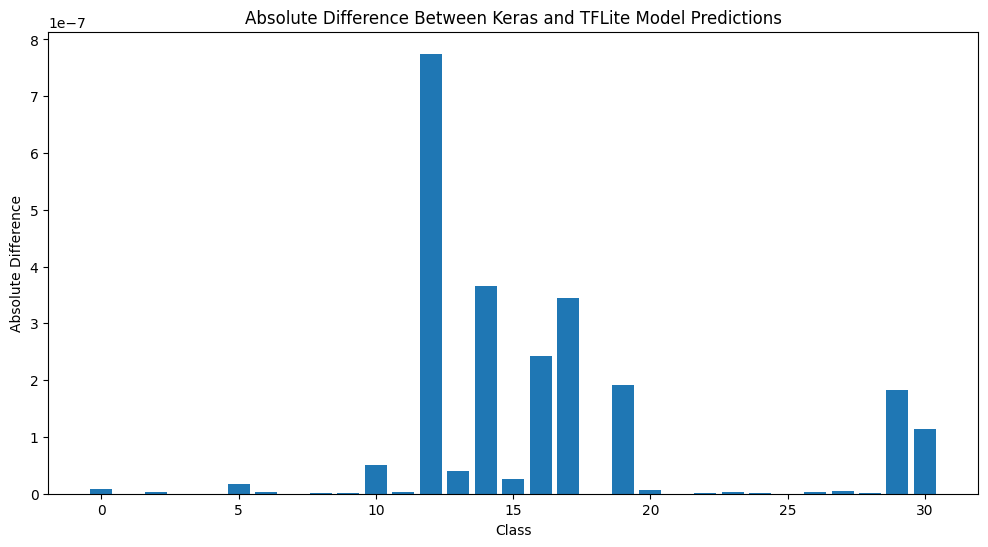

In [31]:
import numpy as np
import matplotlib.pyplot as plt

# Assuming keras_prediction and tflite_prediction are your outputs
difference = np.abs(keras_prediction - tflite_prediction)

# Plot the differences
plt.figure(figsize=(12, 6))
plt.bar(range(len(difference[0])), difference[0])
plt.xlabel('Class')
plt.ylabel('Absolute Difference')
plt.title('Absolute Difference Between Keras and TFLite Model Predictions')
plt.show()


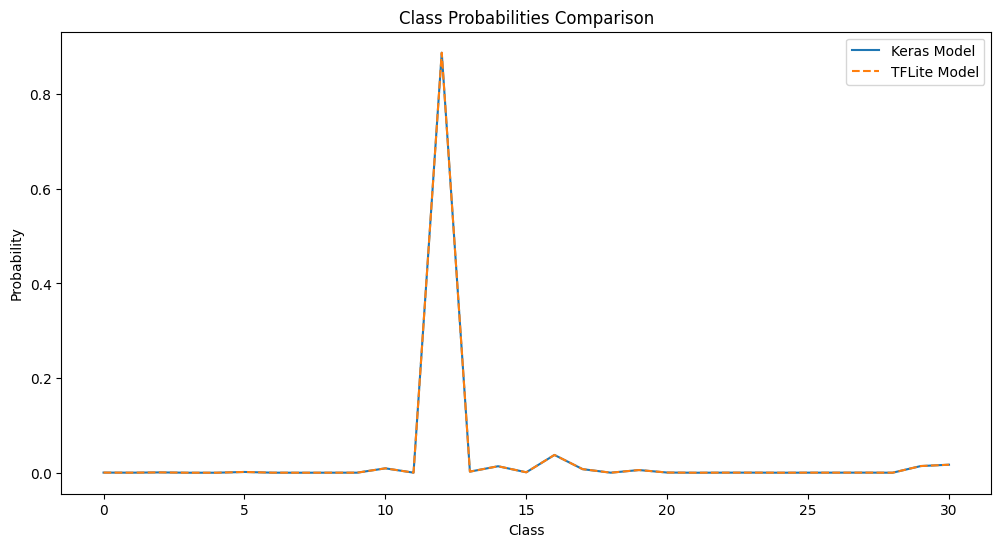

In [32]:
# Plot class probabilities for Keras model
plt.figure(figsize=(12, 6))
plt.plot(keras_prediction[0], label='Keras Model')
plt.plot(tflite_prediction[0], label='TFLite Model', linestyle='dashed')
plt.xlabel('Class')
plt.ylabel('Probability')
plt.title('Class Probabilities Comparison')
plt.legend()
plt.show()


In [39]:
from sklearn.metrics import mean_squared_error

# Calculate MSE
mse = mean_squared_error(keras_predictions_flat, tflite_predictions_flat)
print(f"Mean Squared Error (MSE): {mse:.5f}")


Mean Squared Error (MSE): 0.00000


1/1 [==============================] - 4s 4s/step
Mean Squared Error (MSE): 0.00000
Mean Absolute Error (MAE): 0.00000


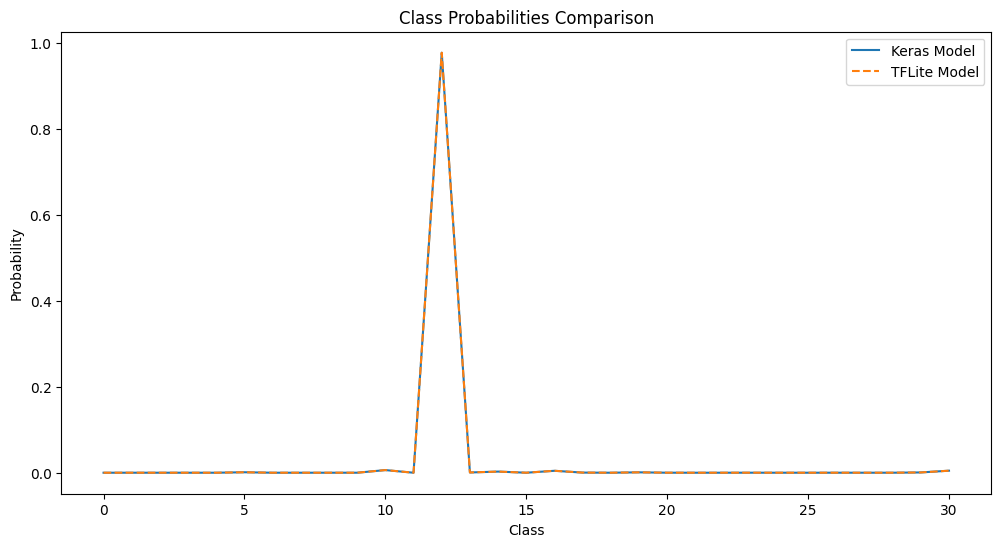

In [40]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, mean_absolute_error

# Load models
keras_model = tf.keras.models.load_model('model.h5')
interpreter = tf.lite.Interpreter(model_path='model.tflite')
interpreter.allocate_tensors()

# Get tensor details
input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()

# Define a function to make predictions
def predict_with_models(input_data):
    # Keras model prediction
    keras_prediction = keras_model.predict(np.expand_dims(input_data, axis=0))

    # TFLite model prediction
    interpreter.set_tensor(input_details[0]['index'], np.expand_dims(input_data, axis=0))
    interpreter.invoke()
    tflite_prediction = interpreter.get_tensor(output_details[0]['index'])

    return keras_prediction, tflite_prediction

# Generate test input data
test_input = np.random.random_sample((160, 160, 3)).astype(np.float32)

# Make predictions
keras_pred, tflite_pred = predict_with_models(test_input)

# Flatten predictions
keras_pred_flat = keras_pred.flatten()
tflite_pred_flat = tflite_pred.flatten()

# Calculate metrics
mse = mean_squared_error(keras_pred_flat, tflite_pred_flat)
mae = mean_absolute_error(keras_pred_flat, tflite_pred_flat)

# Display results
print(f"Mean Squared Error (MSE): {mse:.5f}")
print(f"Mean Absolute Error (MAE): {mae:.5f}")

# Visualize predictions
plt.figure(figsize=(12, 6))
plt.plot(keras_pred_flat, label='Keras Model')
plt.plot(tflite_pred_flat, label='TFLite Model', linestyle='dashed')
plt.xlabel('Class')
plt.ylabel('Probability')
plt.title('Class Probabilities Comparison')
plt.legend()
plt.show()
